# Metacelling workflow DEMO

This demo is based on a subset of HIPSD-seq data from LFS041_p62

In [1]:
# Author of metacelling workflow: Olga Lazareva

import glob
import sys
import warnings

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from sklearn.metrics import pairwise_distances
from tqdm import tqdm

warnings.filterwarnings("ignore")

sys.path.insert(1, "../helper_functions")
from create_metacells import *
from helper_functions import double_figure, gini, lorenz, prepare_counts_df

# Data reading

In [2]:
work_dir = "../data"

In [3]:
# In the case of metacelling we will be reading seg files with 100kb bin size
files = glob.glob(
    "../../aurelie_data/LFS041_p63/atac_only/readCount_filtered_bam/*100kb*.seg"
)

## Data is loaded at 100kb resolution

In [4]:
# combining the counts into a single dataframe
counts_df_orig, regions = prepare_counts_df(files, metacelling=True, binsize=100000)
counts_df_orig.head()

100%|██████████| 4256/4256 [00:00<00:00, 96237.80it/s]


recording


,chr1:1-100001,chr1:100001-200001,chr1:200001-300001,chr1:300001-400001,chr1:400001-500001,chr1:500001-600001,chr1:600001-700001,chr1:700001-800001,chr1:800001-900001,chr1:900001-1000001,...,chrY:56300001-56400001,chrY:56400001-56500001,chrY:56500001-56600001,chrY:56600001-56700001,chrY:56700001-56800001,chrY:56800001-56900001,chrY:56900001-57000001,chrY:57000001-57100001,chrY:57100001-57200001,chrY:57200001-57300001
TTGCCCATCTACTTTG-1,0,0,0,0,0,0,2,4,2,12,...,0,0,0,0,0,12,0,0,0,0
GCCAGCATCCTAAAGC-1,0,0,0,0,0,0,0,0,6,2,...,0,0,0,0,0,11,0,0,0,0
GAAATGATCTACCCGT-1,0,0,0,0,0,0,0,0,6,9,...,0,0,0,0,0,9,0,0,0,0
ACAATCGTCACTCCCA-1,0,0,0,0,0,0,2,0,8,12,...,0,0,0,0,0,4,0,0,0,0
GCACGGTGTGATGTGG-1,0,0,0,0,0,0,14,0,2,6,...,0,0,0,0,0,11,0,0,0,0


# Data initial analysis and filtering

In [5]:
gini_matac = counts_df_orig.apply(lambda row: gini(row), axis=1).values

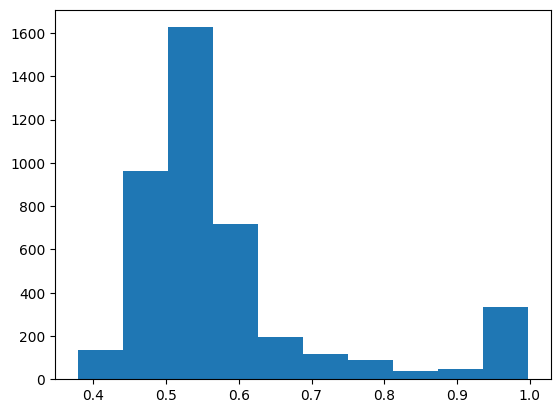

In [6]:
# show the distribution of gini coefficients for each cell
plt.hist(gini_matac)
plt.show()

## Counts distribution to verify the average number of reads per 100kb 

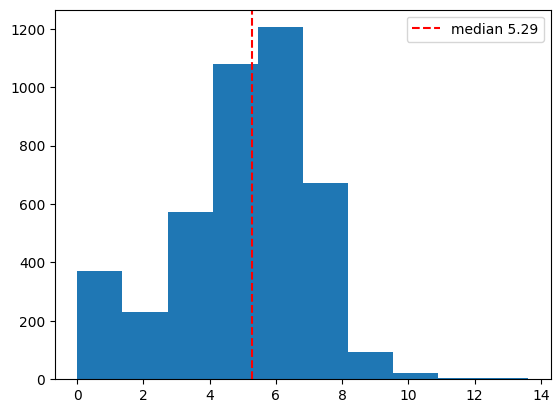

In [7]:
plt.hist(counts_df_orig.mean(axis=1))
m = counts_df_orig.mean(axis=1).median()
plt.axvline(m, label=f"median {m:.2f}", color="red", ls="--")
plt.legend()

# Aggregating counts to 1MB
We need this step for metacelling to reduce data sparcity and improve coverage unformity

In [8]:
counts = counts_df_orig.copy().values
new_step = 1000000  # 1MB
i0 = 0
chrom = "chr1"
start0 = 1
new_counts = []
counts0 = np.zeros(counts_df_orig.shape[0])
new_regions = []
for i, rec in tqdm(enumerate(regions)):
    if rec[0] == chrom and (rec[1] - start0 < new_step):
        counts0 += counts[:, i]
        region = f"{rec[0]}:{start0}-{start0+new_step}"
    else:
        new_counts.append(counts0)
        new_regions.append(region)
        start0 = rec[1]
        counts0 = counts[:, i]
        chrom = rec[0]
        region = f"{rec[0]}:{start0}-{start0+new_step}"

30894it [00:00, 104845.55it/s]


In [9]:
counts_df = pd.DataFrame(new_counts, index=new_regions, columns=counts_df_orig.index).T

In [10]:
counts_df.head()

,chr1:1-1000001,chr1:1000001-2000001,chr1:2000001-3000001,chr1:3000001-4000001,chr1:4000001-5000001,chr1:5000001-6000001,chr1:6000001-7000001,chr1:7000001-8000001,chr1:8000001-9000001,chr1:9000001-10000001,...,chrY:47000001-48000001,chrY:48000001-49000001,chrY:49000001-50000001,chrY:50000001-51000001,chrY:51000001-52000001,chrY:52000001-53000001,chrY:53000001-54000001,chrY:54000001-55000001,chrY:55000001-56000001,chrY:56000001-57000001
TTGCCCATCTACTTTG-1,20.0,105.0,54.0,120.0,67.0,79.0,138.0,118.0,137.0,79.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
GCCAGCATCCTAAAGC-1,8.0,49.0,78.0,95.0,73.0,112.0,131.0,126.0,104.0,94.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0
GAAATGATCTACCCGT-1,15.0,52.0,54.0,74.0,44.0,48.0,63.0,49.0,38.0,56.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
ACAATCGTCACTCCCA-1,22.0,94.0,131.0,114.0,82.0,114.0,133.0,94.0,101.0,105.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
GCACGGTGTGATGTGG-1,22.0,38.0,94.0,139.0,137.0,131.0,70.0,61.0,28.0,34.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0


In [11]:
# save intermidiate results to csv files
counts_df.to_csv("../data/raw_counts_1mb.csv")

# Create andata object for further analysis

## The object creation and QC

In [12]:
adata = sc.AnnData(counts_df)

In [13]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

In [14]:
adata.obs.rename(
    columns={"n_genes_by_counts": "n_features_per_cell"},
    inplace=True,
)

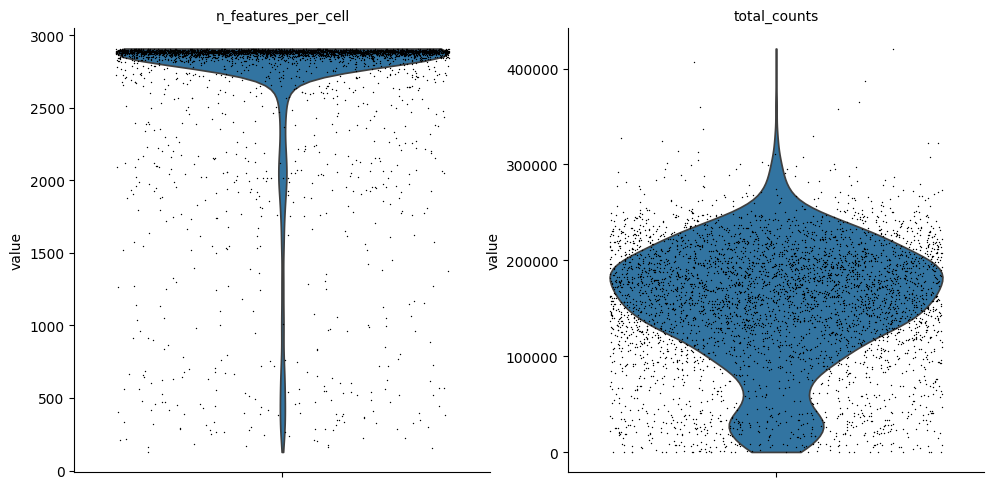

In [15]:
sc.pl.violin(
    adata, ["n_features_per_cell", "total_counts"], jitter=0.4, multi_panel=True
)

### Filter cells based on the number of non-empty genomic bins. This is sample specific and you should decide on the exact cutoff based on single-cell workflow

In [16]:
adata = adata[adata.obs.n_features_per_cell > (0.9 * len(adata.var_names))]

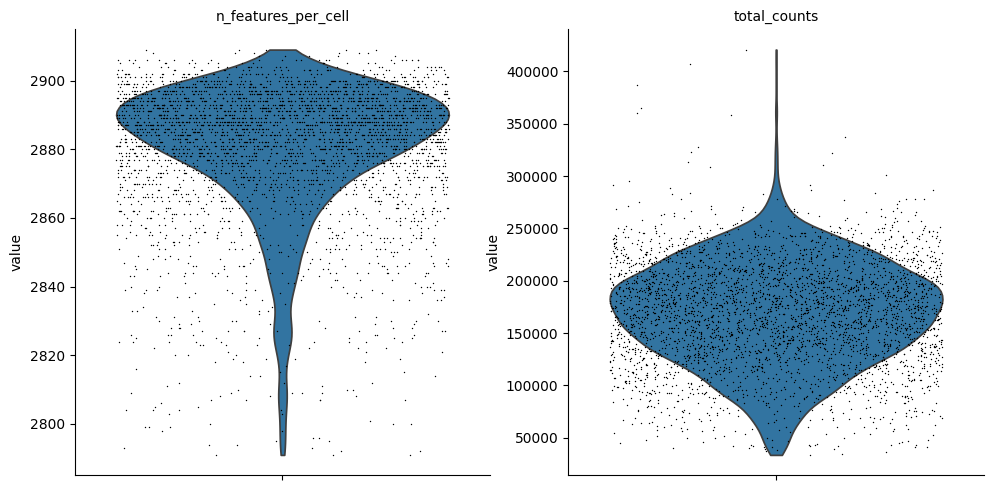

In [17]:
sc.pl.violin(
    adata, ["n_features_per_cell", "total_counts"], jitter=0.4, multi_panel=True
)

In [18]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

## Calculate PCA and UMAP

In [19]:
# Increase the number of num_comp if the variance ratio is around 0.95
# This step might take some time
num_comp = 1000
sc.tl.pca(adata, svd_solver="arpack", n_comps=num_comp)
print(np.cumsum(adata.uns["pca"]["variance_ratio"])[-1])

0.9110178796966333


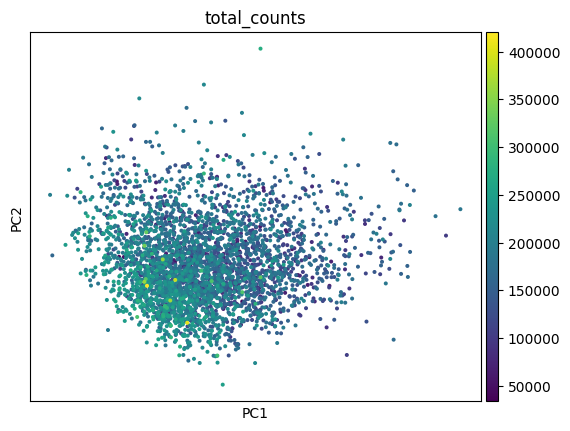

In [20]:
sc.pl.pca(adata, color="total_counts")

In [21]:
sc.pp.neighbors(adata, n_pcs=num_comp)
# if this step fails with a memory error, try setting n_pcs to a lower value

In [22]:
# compute UMAP
sc.tl.leiden(adata)
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)
sc.tl.umap(adata, init_pos="paga")

# Metacelling

## Create initial metacells

In [23]:
# Those are parameters for initial metacells
# Do not modify them unless you know what you are doing
max_coverage = 1100
min_coverage = 200

In [24]:
# set the resolution such that the maximum coverage is close to max_covergae
# higher resolution =>  lower maximum coverage
sc.tl.leiden(adata, resolution=75, key_added="leiden_small")
clust_df = []
clusters = adata.obs.leiden_small.unique()
for meta in clusters:
    dat = adata.obs[adata.obs.leiden_small == meta]
    subset = adata[dat.index]
    clust_df.append(
        [
            meta,
            counts_df.loc[dat.index].sum(axis=0).mean(),
            subset.shape[0],
            float(subset.obsm["X_umap"][:, 0].mean()),
            float(subset.obsm["X_umap"][:, 1].mean()),
            # float(subset.obsm['X_pca'][:,0].mean()),float(subset.obsm['X_pca'][:,1].mean()),
            *subset.obsm["X_pca"].mean(axis=0),
        ]
    )
clust_df = pd.DataFrame(
    clust_df,
    columns=[
        "cl",
        "coverage",
        "n_cells",
        "umap_x",
        "umap_y",
        *[f"PC_{i}" for i in range(num_comp)],
    ],
)
print(
    f"Maximal coverage for initial metacells {clust_df.coverage.max()} (should be close to {max_coverage})"
)

Maximal coverage for initial metacells 1001.3605288616575 (should be close to 1100)


In [25]:
clust_df["pass_min"] = clust_df.coverage >= min_coverage
clust_df["pass_max"] = clust_df.coverage <= min_coverage
adata.obs["counts_per_1MB"] = adata.obs["total_counts"] / adata.var.shape[0]

In [26]:
clust_df

,cl,coverage,n_cells,umap_x,umap_y,PC_0,PC_1,PC_2,PC_3,PC_4,...,PC_992,PC_993,PC_994,PC_995,PC_996,PC_997,PC_998,PC_999,pass_min,pass_max
0,9,650.518220,9,13.131743,17.953114,-19.862671,3.377950,2.939434,-1.907366,3.961073,...,0.349660,0.060525,0.047254,0.103900,0.027042,0.050261,0.181821,-0.034738,True,False
1,65,429.515963,7,13.837068,13.235537,-1.145030,0.389018,4.243035,-4.841950,-2.058589,...,-0.066419,0.304828,-0.164793,0.017746,0.149951,-0.114825,0.073503,-0.261240,True,False
2,622,158.376008,3,15.537407,13.060822,-0.490779,-7.256698,-1.966904,0.287978,-3.428530,...,-0.108576,-0.012224,-0.307027,0.252628,-0.005678,-0.327902,0.046508,0.219403,False,True
3,380,290.237343,4,14.018147,15.574009,-10.970327,-0.420508,2.662336,-3.778039,-0.429666,...,0.071308,0.179828,0.091121,0.171147,-0.194310,-0.010267,-0.139604,-0.408484,True,False
4,357,179.470493,4,13.790449,9.343947,14.698114,-3.652811,1.147883,0.464977,-1.613138,...,-0.064549,-0.139406,-0.096847,-0.261635,0.193317,0.078632,-0.214187,-0.159376,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
927,910,25.525314,1,15.747518,11.260547,4.900116,-6.479890,2.215540,7.989245,-5.190740,...,-0.539896,0.396391,0.399305,-0.523433,0.075433,1.044390,-0.829166,0.409819,False,True
928,926,28.262173,1,13.897175,8.296420,25.169207,-0.863275,0.941313,-3.318833,-5.561179,...,-0.315372,-0.066780,-0.558097,-0.256654,0.065200,0.108862,-0.653902,0.321822,False,True
929,794,45.004192,1,14.364176,10.961246,3.469163,-5.251209,0.416900,-3.548432,1.906182,...,0.069085,0.262332,-0.335206,-0.668352,0.462798,-0.312767,-0.751508,-0.020340,False,True
930,911,43.223154,1,15.930580,14.406455,-2.058496,-9.272022,-3.096461,6.335602,-5.260943,...,-0.091614,0.317208,-0.132573,-0.130226,0.403889,-0.084700,0.311535,-0.715935,False,True


In [27]:
palette = sns.color_palette("Purples", as_cmap=True)
custom_colormap = mcolors.LinearSegmentedColormap.from_list(
    "CustomPurple", [(0, palette(0.4)), (0.4, palette(0.8)), (1, palette(0.9))]
)

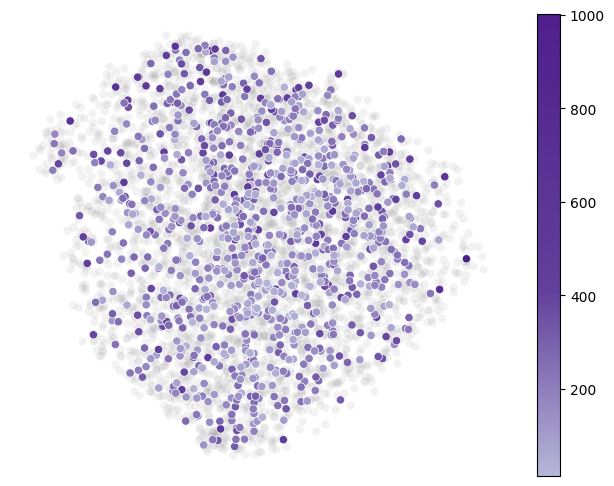

In [28]:
# show the initial pre metacells assigment
# it should cover the whole phenotipic space
f, ax = plt.subplots(figsize=(8, 6))

p1 = sns.scatterplot(
    x=adata.obsm["X_umap"][:, 0],
    y=adata.obsm["X_umap"][:, 1],
    alpha=0.1,
    color="grey",
    ax=ax,
)
p2 = sns.scatterplot(
    x=clust_df.umap_x,
    y=clust_df.umap_y,
    hue=clust_df.coverage,
    palette=custom_colormap,
    ax=ax,
)

norm = plt.Normalize(clust_df.coverage.min(), clust_df.coverage.max())
sm = plt.cm.ScalarMappable(cmap=custom_colormap, norm=norm)
sm.set_array([])

p2.get_legend().remove()
p2.figure.colorbar(sm)
ax.set_frame_on(False)
ax.axes.get_yaxis().set_visible(False)
ax.axes.get_xaxis().set_visible(False)
plt.show()

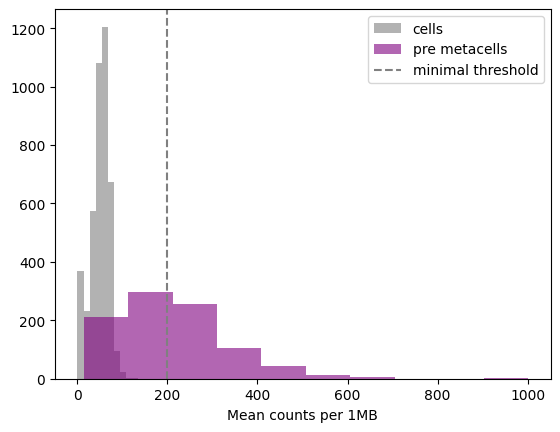

In [29]:
# Counts distribution per 1MB
plt.hist(counts_df.mean(axis=1), label="cells", alpha=0.6, color="grey")
plt.hist(clust_df.coverage, alpha=0.6, label="pre metacells", color="purple")

plt.axvline(200, label="minimal threshold", ls="--", color="grey")
plt.legend()
plt.xlabel("Mean counts per 1MB")
plt.show()

In [30]:
# compute distance between premetacells
pcs = [x for x in clust_df.columns if x.startswith("PC")]
dist = pairwise_distances(clust_df[pcs])

## Selection of the optimal distance between two points to be merged into one metacell

Selection of the distance has large impact on the metacelling results.
To get a good intuition about different thresholds, we compute 10 quantiles of all possible distances

In [31]:
ts = np.quantile(
    dist[np.triu_indices(dist.shape[0], k=1)], np.linspace(0.01, 1, num=10)
)

In [32]:
# This step my take up to 30 minutes to run depending on the size of the dataset
# If it takes too long, reuduce the number of quantiles in the cell above
results = []
tmp = pd.DataFrame(adata.X, index=adata.obs.index, columns=adata.var.index)
for i, d_tresh in enumerate(ts):
    print(f"Starting run {i}: th. {d_tresh:.2f}")
    (
        new_df,
        cell_dict,
    ) = merge_cells(
        d_tresh, clust_df, "leiden_small", adata, min_coverage, max_coverage
    )
    num_meta = new_df.shape[0]
    size_meta = new_df.n_cells.median()
    excluded = len([cell for cell in cell_dict if cell_dict[cell] == "-1"])
    med_cov = new_df.coverage.median()
    reversed_dict = {
        value: [key for key in cell_dict if cell_dict[key] == value]
        for value in set(cell_dict.values())
    }
    stds = [tmp.loc[reversed_dict[key]].std().mean() for key in reversed_dict]
    results.append((d_tresh, num_meta, size_meta, excluded, med_cov, np.mean(stds)))
    print(
        f"Done with run {i}: th. {d_tresh:.2f}, # metacells {num_meta}, median size {size_meta}, {excluded} cells excluded, median coverage {med_cov:.2f}"
    )

Starting run 0: th. 18.37
metacells to process: 465
Iteration 0
metacells to process: 80
Iteration 1
metacells to process: 78
Iteration 2
metacells to process: 78
stagnation
Iteration 3
metacells to process: 42
Iteration 4
metacells to process: 27
Iteration 5
metacells to process: 25
Iteration 6
metacells to process: 25
stagnation
Iteration 7
metacells to process: 5
Iteration 8
metacells to process: 3
Iteration 9
metacells to process: 3
stagnation
Iteration 10
metacells to process: 0
DONE with 469 metacells in total
Done with run 0: th. 18.37, # metacells 469, median size 5.0, 893 cells excluded, median coverage 286.43
Starting run 1: th. 23.06
metacells to process: 465
Iteration 0
metacells to process: 288
Iteration 1
metacells to process: 283
Iteration 2
metacells to process: 283
stagnation
Iteration 3
metacells to process: 179
Iteration 4
metacells to process: 134
Iteration 5
metacells to process: 130
Iteration 6
metacells to process: 130
stagnation
Iteration 7
metacells to process:

In [33]:
# Aggregate results from metacell analysis
res = pd.DataFrame(
    results,
    columns=[
        "t",
        "# metacells",
        "median_meta_size",
        "cells_excluded",
        "median_coverage",
        "mean_std",
    ],
)
res.cells_excluded = res.cells_excluded / adata.obs.shape[0]

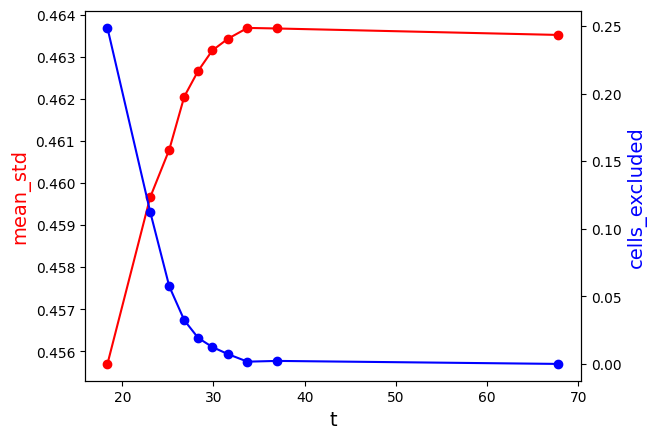

In [34]:
double_figure(res, "t", "mean_std", "cells_excluded")

In [35]:
# a reasonable threshold for the distance depends on the desired trade-off between the proportion of cells that will be lost
# (right y scale) and variance within metacell. In this example we assume that we don't want to lose more that 10% of
# cells and therefore we choose 4th value of t as the distance threshold
(
    new_df,
    cell_dict,
) = merge_cells(ts[4], clust_df, "leiden_small", adata, min_coverage, max_coverage)

metacells to process: 465
Iteration 0
metacells to process: 402
Iteration 1
metacells to process: 399
Iteration 2
metacells to process: 399
stagnation
Iteration 3
metacells to process: 258
Iteration 4
metacells to process: 233
Iteration 5
metacells to process: 230
Iteration 6
metacells to process: 230
stagnation
Iteration 7
metacells to process: 140
Iteration 8
metacells to process: 116
Iteration 9
metacells to process: 114
Iteration 10
metacells to process: 114
stagnation
Iteration 11
metacells to process: 62
Iteration 12
metacells to process: 44
Iteration 13
metacells to process: 42
Iteration 14
metacells to process: 42
stagnation
Iteration 15
metacells to process: 8
Iteration 16
metacells to process: 6
Iteration 17
metacells to process: 6
stagnation
Iteration 18
metacells to process: 0
DONE with 493 metacells in total


## Visualization of metacelling results

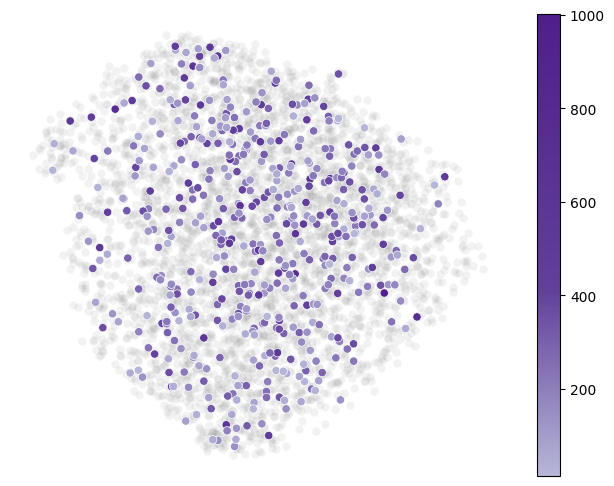

In [36]:
f, ax = plt.subplots(figsize=(8, 6))

p1 = sns.scatterplot(
    x=adata.obsm["X_umap"][:, 0],
    y=adata.obsm["X_umap"][:, 1],
    alpha=0.1,
    color="grey",
    ax=ax,
)
p2 = sns.scatterplot(
    x=new_df.umap_x,
    y=new_df.umap_y,
    hue=new_df.coverage,
    palette=custom_colormap,
    ax=ax,
)

norm = plt.Normalize(clust_df.coverage.min(), clust_df.coverage.max())
sm = plt.cm.ScalarMappable(cmap=custom_colormap, norm=norm)
sm.set_array([])

p2.get_legend().remove()
p2.figure.colorbar(sm)
ax.set_frame_on(False)
ax.axes.get_yaxis().set_visible(False)
ax.axes.get_xaxis().set_visible(False)


plt.show()

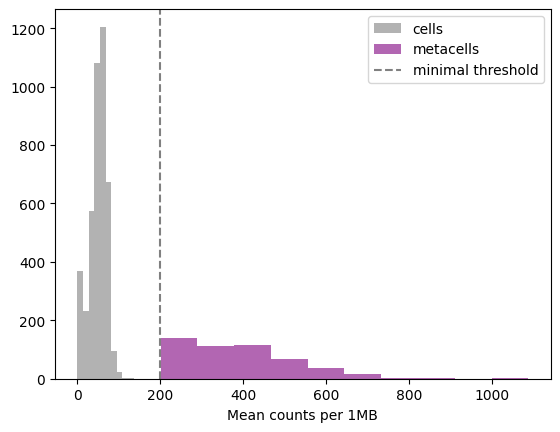

In [37]:
plt.hist(counts_df.mean(axis=1), label="cells", alpha=0.6, color="grey")
plt.hist(new_df.coverage, alpha=0.6, label="metacells", color="purple")

plt.axvline(200, label="minimal threshold", ls="--", color="grey")
plt.legend()
plt.xlabel("Mean counts per 1MB")
plt.show()

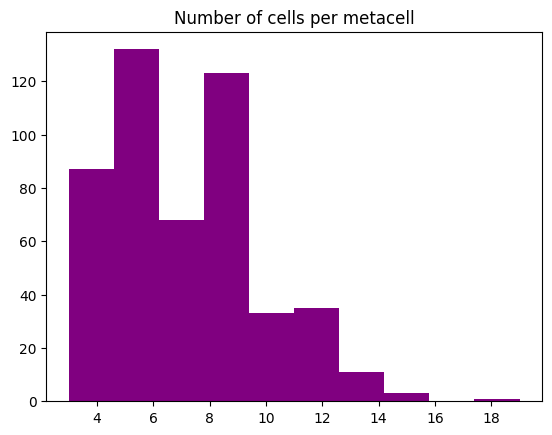

In [38]:
plt.title("Number of cells per metacell")
plt.hist(new_df.n_cells, color="purple")
plt.show()

In [ ]:
# path where to save metacells (make sure it exists)
mc_path = work_dir + "metacells/"

In [ ]:
# here we save paths to the readcounts files for each metacell
# make sure that the paths are correct
# here my readcounts files are in the folder readCount_filtered_bam and have the name readcounts.100kb.cell_bc_{cell}.seg
for mc in tqdm(new_df.cl):
    cells = [x for x in cell_dict if cell_dict[x] == mc]

    with open(f"{mc_path}{mc}.txt", "a") as the_file:
        for cell in cells:
            full_path = f"readCount_filtered_bam/readcounts.100kb.cell_bc_{cell}.seg"
            the_file.write(f"{full_path}\n")